In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

import gpytorch.kernels as kernels
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.utils.cholesky import psd_safe_cholesky


from time_series_generator import SyntheticTimeSeriesGenerator
from time_series_dataset import TimeSeriesDataset


from gp_kernel_factory import KernelBuilder

from curriculum_sampler import CurriculumSampler
from inducing_point_sampler import InducingPointSampler
from variational_gp_model import VariationalGPModel
from gp_trainer import GPTrainer

import gp_plotting as gpplt



# Generate Data

In [2]:
generator = SyntheticTimeSeriesGenerator(
    num_series=10,
    series_length=100,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.2,
    low_signal_scale=0.02,
    seed=42
)


In [3]:
df = generator.generate()
df.head()

,series_id,timestep,value,long_term,short_term,seasonal,noise,signal_strength
0,0,0,0.623134,-0.304745,0.356749,0.619443,-0.048312,high
1,0,1,0.667371,-0.289607,0.418308,0.595653,-0.056983,high
2,0,2,0.480881,-0.274396,0.452055,0.512382,-0.209160,high
3,0,3,0.689938,-0.259115,0.444735,0.377945,0.126374,high
4,0,4,0.356662,-0.243770,0.396213,0.205768,-0.001548,high


In [4]:
# Generate data
df = generator.generate()

# Create dataset (return trend components later if needed)
dataset = TimeSeriesDataset(df)

# Mini-batch 4 time series at a time
batch_size = 4
T = df['timestep'].unique().shape[0]  # Number of timesteps
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example training loop
for batch_x, batch_y in loader:
    print(batch_x.shape) #: [batch_size, T, 1]
    print(batch_y.shape) #: [batch_size, T]
    pass

torch.Size([4, 100, 1])
torch.Size([4, 100])
torch.Size([4, 100, 1])
torch.Size([4, 100])
torch.Size([2, 100, 1])
torch.Size([2, 100])


# Viz Data

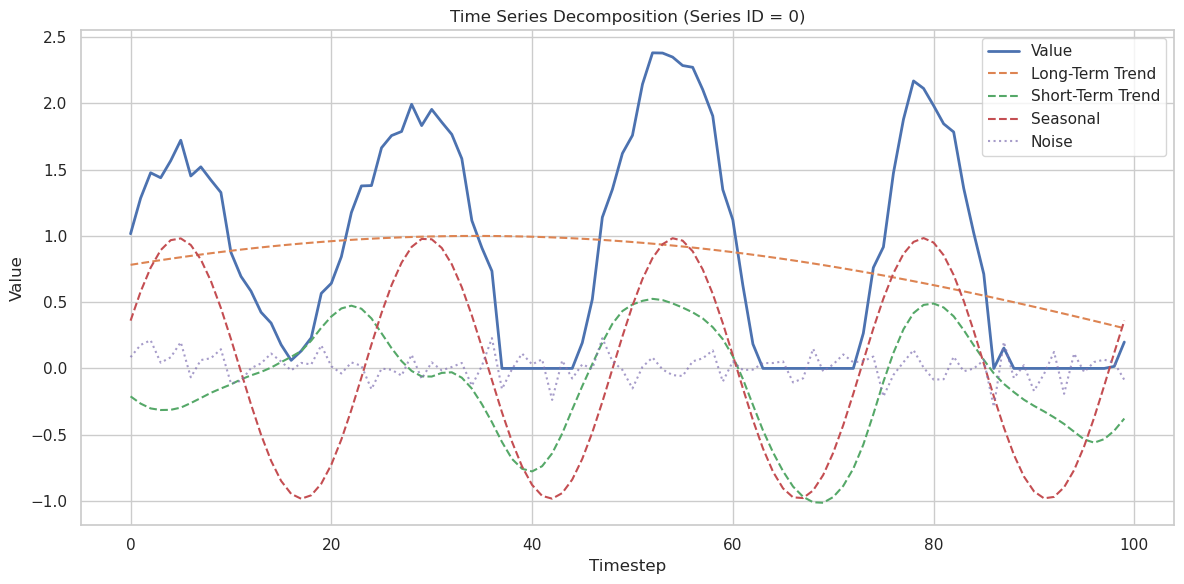

In [5]:
import gp_plotting as gpplt

# Plot a single series with components
gpplt.plot_single_series(df, series_id=0)


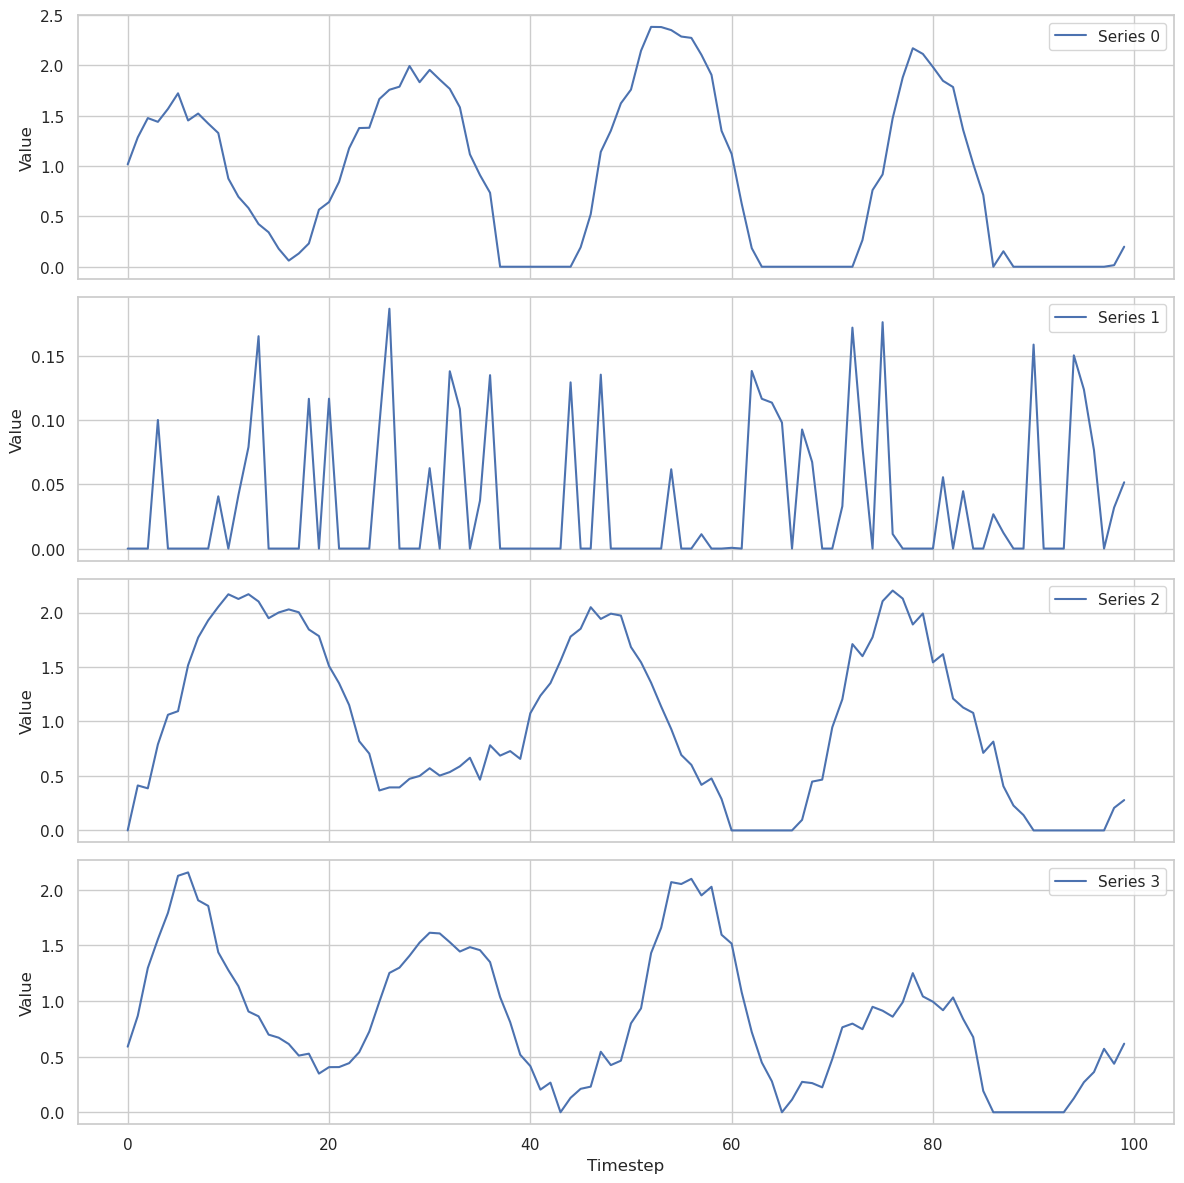

In [6]:
# Plot the first 4 series (just raw value)
gpplt.plot_multiple_series(df, n=4)


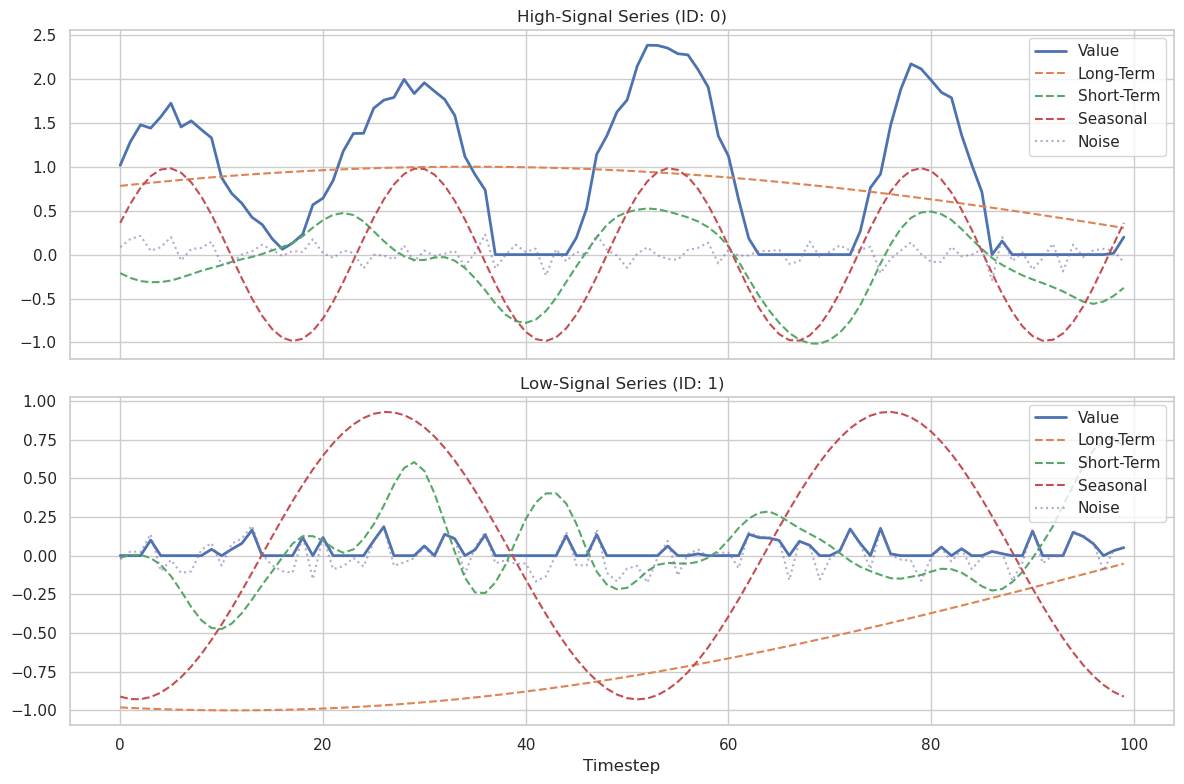

In [7]:
# Visualize high vs low signal comparison
gpplt.plot_signal_vs_noise_comparison(df)

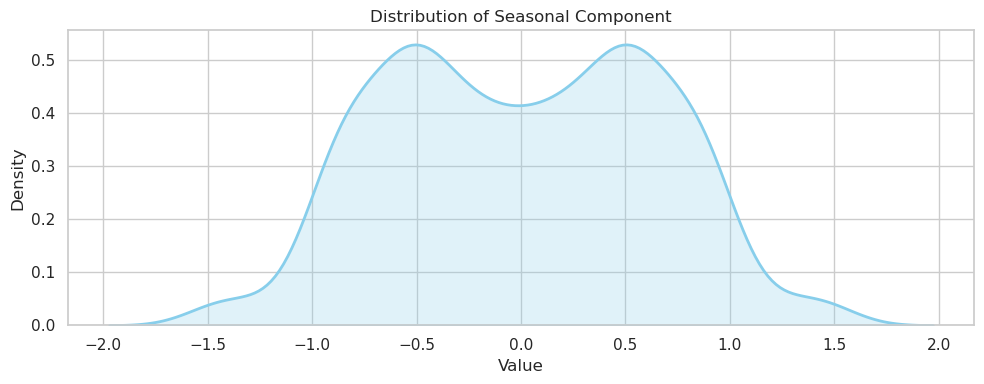

In [8]:
gpplt.plot_component_distributions(df, component="seasonal")


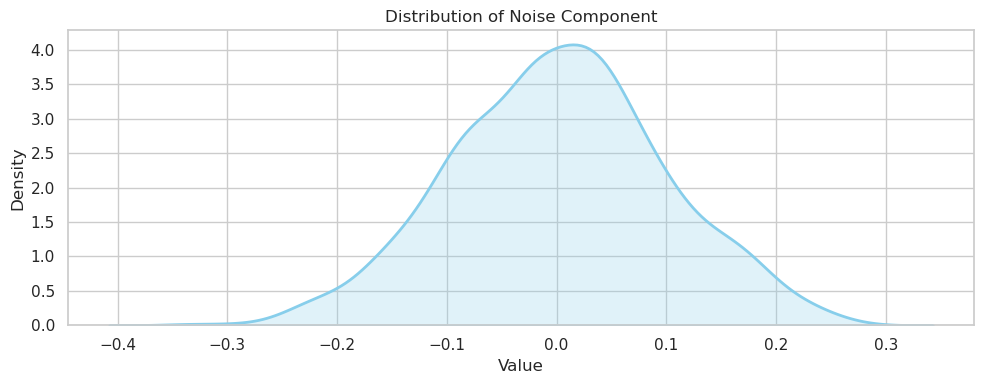

In [9]:
gpplt.plot_component_distributions(df, component="noise")


# Kernel

In [10]:
kernel_config = {
    "type": "add",
    "components": [
        # Long-term trend (smooth)
        {
            "type": "scale",
            "outputscale_prior": {"mean": 1.0, "stddev": 0.3},
            "base_kernel": {
                "type": "RBF",  # very smooth
                "lengthscale_prior": {"mean": 2.0, "stddev": 0.5}
            }
        },

        # Short-term trend (less smooth)
        {
            "type": "scale",
            "outputscale_prior": {"mean": 0.5, "stddev": 0.2},
            "base_kernel": {
                "type": "Matern",
                "nu": 2.5,  # options: 0.5 (rough), 1.5, 2.5 (smoother)
                "lengthscale_prior": {"mean": 0.2, "stddev": 0.1}
            }
        },

        # Seasonal trend (periodic)
        {
            "type": "scale",
            "outputscale_prior": {"mean": 1.0, "stddev": 0.1},
            "base_kernel": {
                "type": "Periodic",
                "period_length": 0.25,
                "lengthscale_prior": {"mean": 0.3, "stddev": 0.1}
            }
        },

    ]
}



In [11]:
# Assume kernel_config from earlier (with Matern short-term trend)
kernel = KernelBuilder(kernel_config).build()

print(kernel)
# This is now a fully usable GPyTorch kernel


AdditiveKernel(
  (kernels): ModuleList(
    (0): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (lengthscale_prior): NormalPrior()
      )
      (raw_outputscale_constraint): Positive()
      (outputscale_prior): NormalPrior()
    )
    (1): ScaleKernel(
      (base_kernel): MaternKernel(
        (raw_lengthscale_constraint): Positive()
        (lengthscale_prior): NormalPrior()
      )
      (raw_outputscale_constraint): Positive()
      (outputscale_prior): NormalPrior()
    )
    (2): ScaleKernel(
      (base_kernel): PeriodicKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_period_length_constraint): Positive()
        (lengthscale_prior): NormalPrior()
      )
      (raw_outputscale_constraint): Positive()
      (outputscale_prior): NormalPrior()
    )
  )
)


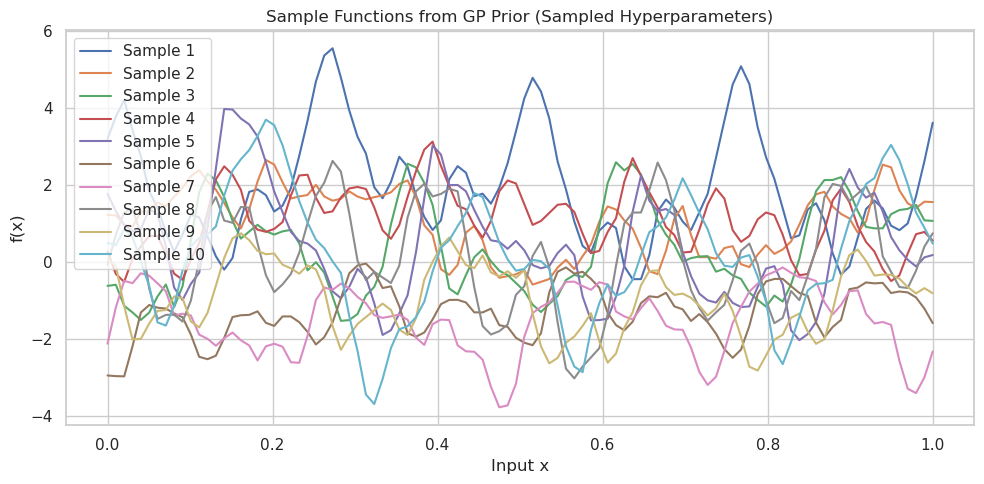

In [12]:
from gp_plotting import plot_kernel_prior_samples

plot_kernel_prior_samples(kernel_config, num_samples=10, seed=42)


# Curriculum Sampler

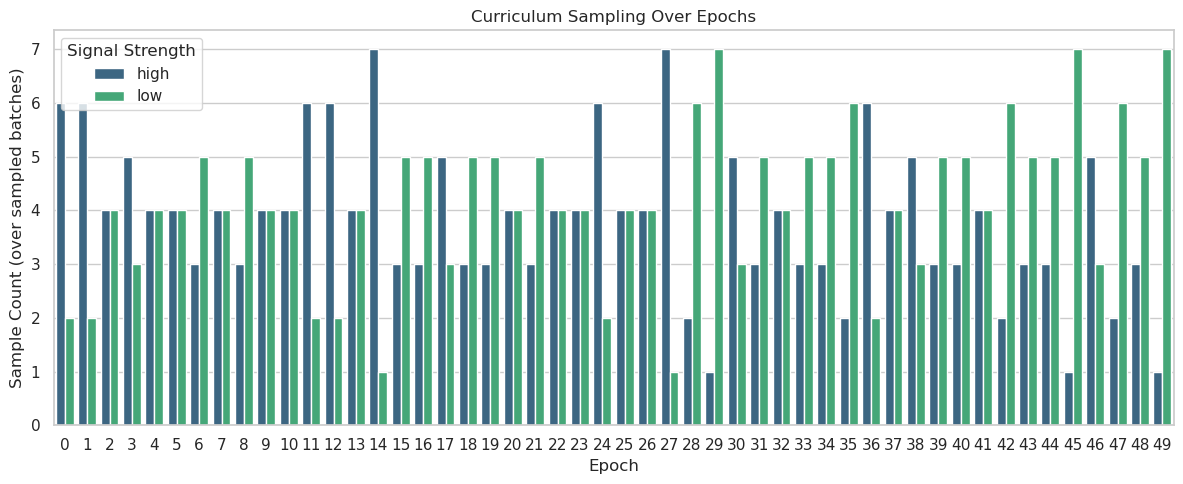

In [13]:
# Create sampler
sampler = CurriculumSampler(
    dataset,
    curriculum_strength=0.05,
    max_epochs=30,
    batch_size=8,
    seed=42
)

gpplt.plot_curriculum_progression_over_epochs(
    sampler,
    dataset,
    num_batches=100,
    num_epochs=50
)

# Inducing Point Sampler

In [14]:
# Step 1: Create dataset from your synthetic dataframe
dataset = TimeSeriesDataset(df)

# Step 2: Standard DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=8,         # full time series per batch
    shuffle=True          # optional: True if random sampling
)


In [15]:

sampler = CurriculumSampler(
    dataset,
    curriculum_strength=0.8,
    max_epochs=30,
    batch_size=8,
    seed=42
)

# Set current epoch
sampler.set_epoch(0)

# DataLoader using our sampler
dataloader = DataLoader(
    dataset,
    batch_sampler=sampler
)

In [16]:
inducer = InducingPointSampler(dataset, strategy="high_signal_only")
inducing_points = inducer.sample(num_points=64)  # Shape: [64, 1]

# In model:
# self.variational_strategy = VariationalStrategy(self, inducing_points, ...)


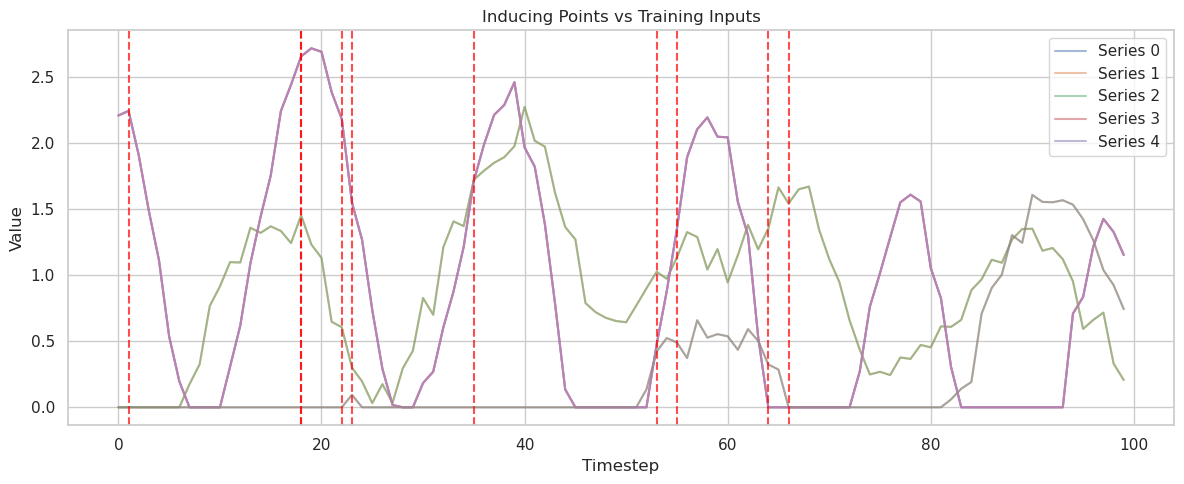

In [17]:
for x_batch, y_batch in dataloader:
    inducing_points = inducer.sample(num_points=10)
    gpplt.plot_inducing_points_vs_inputs(x_batch, y_batch, inducing_points)
    break  # just once for inspection


# Model Class

In [18]:
# set logging level
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("This is an info message.")

INFO:__main__:This is an info message.


In [19]:
# Build GP model
model = VariationalGPModel(
    inducing_points=inducing_points,
    kernel_config=kernel_config,
    learn_inducing_points=True
)

likelihood = GaussianLikelihood()


# Training Loop

In [20]:
generator = SyntheticTimeSeriesGenerator(
    num_series=100,
    series_length=100,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.3,
    low_signal_scale=0.2,
    seed=42
)

df = generator.generate()


sampler = CurriculumSampler(
    dataset,
    curriculum_strength=0.1,
    max_epochs=100,
    batch_size=32,
    seed=42
)

# Set current epoch
sampler.set_epoch(0)


dataset = TimeSeriesDataset(df)
dataloader = DataLoader(dataset, batch_sampler = sampler)
#dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

inducer = InducingPointSampler(dataset, strategy="grid") # ['random', 'high_signal_only', 'grid'
inducing_points = inducer.sample(num_points=64)



In [21]:
kernel_config = {
    "type": "add",
    "components": [
        # Long-term trend
        {
            "type": "scale",
            "outputscale_prior": {"mean": 1.0, "stddev": 0.3},
            "base_kernel": {
                "type": "RBF",
                "lengthscale_prior": {"mean": 2.0, "stddev": 0.5}
            }
        },
        # Short-term trend
        {
            "type": "scale",
            "outputscale_prior": {"mean": 0.5, "stddev": 0.2},
            "base_kernel": {
                "type": "Matern",
                "nu": 2.5,
                "lengthscale_prior": {"mean": 0.2, "stddev": 0.1}
            }
        },
        # Seasonal trend
        {
            "type": "scale",
            "outputscale_prior": {"mean": 1.0, "stddev": 0.1},
            "base_kernel": {
                "type": "Periodic",
                "period_length": 0.25,
                "lengthscale_prior": {"mean": 0.3, "stddev": 0.1}
            }
        },

    ]
}



In [22]:
model = VariationalGPModel(inducing_points, kernel_config)
likelihood = GaussianLikelihood()
likelihood.noise = torch.tensor(1e-1)  # optional: initialize

VariationalGPModel.check_K_zz(model)

trainer = GPTrainer(
    model=model,
    likelihood=likelihood,
    train_loader=dataloader,
    optimizer_config={"lr": 0.01}
)

trainer.train(num_epochs=10, checkpoint_path="checkpoints/gp_model/")


✅ K_zz is stable


INFO:gp_trainer:[Epoch   1] Avg Loss: 0.0000
INFO:gp_trainer:[Epoch   2] Avg Loss: 0.0000
INFO:gp_trainer:[Epoch   3] Avg Loss: 0.0000
INFO:gp_trainer:[Epoch   4] Avg Loss: 0.0000
INFO:gp_trainer:[Epoch   5] Avg Loss: 0.0000
INFO:gp_trainer:[Epoch   6] Avg Loss: 0.0000
INFO:gp_trainer:[Epoch   7] Avg Loss: 0.0000
INFO:gp_trainer:[Epoch   8] Avg Loss: 0.0000
INFO:gp_trainer:[Epoch   9] Avg Loss: 0.0000
INFO:gp_trainer:[Epoch  10] Avg Loss: 0.0000


[WARNING] Failed to sample posterior, falling back to prior: name 'gpytorch' is not defined


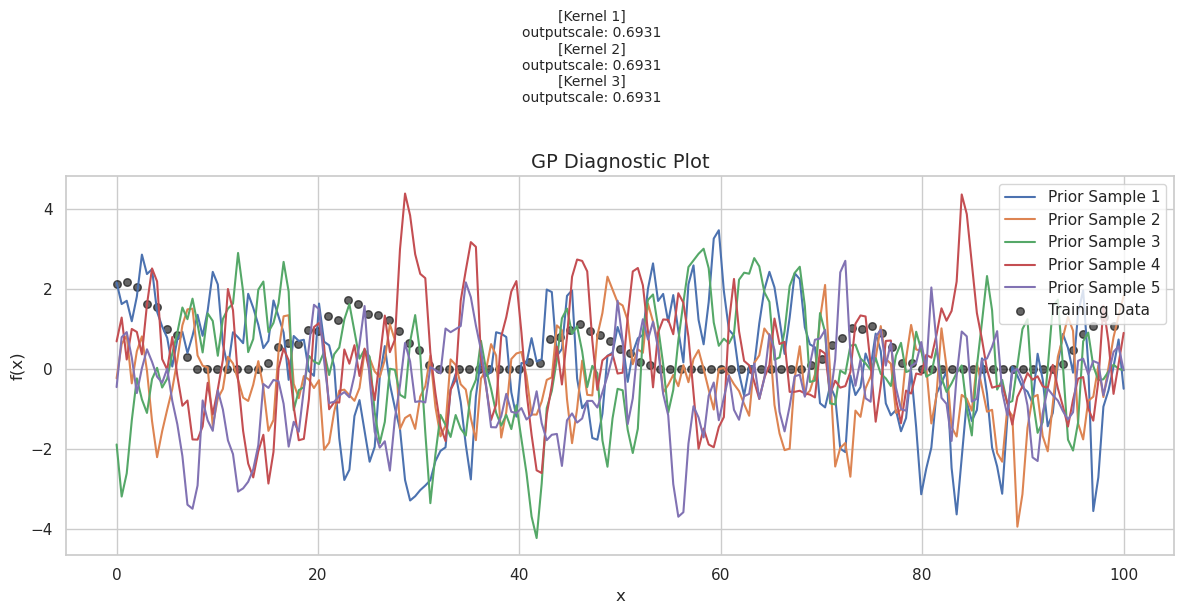

In [58]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)
x_train, y_train = next(iter(loader))

gpplt.plot_gp_diagnostics(
    model=model,
    likelihood=likelihood,
    num_samples=5,
    include_data=(x_train[0], y_train[0]),
    x_range=(0, 100),
    posterior=True,
)


In [24]:






    for x, y in dataloader:
        # Train on batch (x: [B, T, 1], y: [B, T])
        pass
